## 1.- Import standard libraries

In [1]:
# Import custom libraries from local folder.
from importlib import reload
import os
import sys
sys.path.append("..")

# Import nn module from torch to replicate kessler tool
import torch
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Import utils library containing miscellaneous functions/classes
from scalib import utils

# Import library to import Kelvins challlenge data
from scalib.eda import kelvins_challenge_events

# Import SCALIB modules for NN development
import scalib.xnn as xnn            # NN models

# Set overall seed for reproducibility
utils.seed(1)

# Import matplotlib library and setup environment for plots
%matplotlib inline
%config InlineBackend.figure_format='retina'
from matplotlib import rc

# Set rendering parameters to use TeX font if not working on Juno app.
if not '/private/var/' in utils.cwd:
    rc('font', **{'family': 'serif', 'serif': ['Computer Modern'], 'size': 11})
    rc('text', usetex=True)

print(utils.cwd)

/Users/jjrr/Documents/SCA-Project/scalib


## 2.- Data preparation

In [2]:
#As an example, we first show the case in which the data comes from the Kelvins competition.
#For this, we built a specific converter that takes care of the conversion from Kelvins format
#to standard CDM format (the data can be downloaded at https://kelvins.esa.int/collision-avoidance-challenge/data/):
filepath = os.path.join(utils.cwd,'data','esa-challenge','train_data.csv')

# Get ConjunctionEventsDataset object 
events = kelvins_challenge_events(filepath,
            drop_features = ['c_rcs_estimate', 't_rcs_estimate'], 
            num_events = 2000)

# Get features to train the model.
nn_features = events.common_features(only_numeric=True)

# Define input and output size of the RNN model.
input_size = len(nn_features)
output_size = len(nn_features)

# Split data into a test set (5% of the total number of events)
len_test_set=int(0.05*len(events))

# Get Events to test model: used to compute the error the model would have in 
# run-mode.
events_test=events[-len_test_set:]
print('\nTest data:', events_test)

# Get events used for training and validation:
# - Training set: Used to train the model and backpropagate the loss.
# - Validation set: Used to compute the loss so that hyperparameters can be 
#   adjusted.
events_train_and_val=events[:-len_test_set]
print('Training and validation data:', events_train_and_val)

Kelvins Challenge dataset imported from external file (162634 entries):
/Users/jjrr/Documents/SCA-Project/scalib/data/esa-challenge/train_data.csv

KELVINS DATASET IMPORT:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:10s |  192.90   | Dataset imported (2000 events).         

CONJUNCTION EVENTS DATASET -> PANDAS DATAFRAME:
| Progress                     |    Time     | Iters/sec | Comments
| 100% |██████████| (2000/2000)| 00h:00m:31s |   63.73   | Pandas DataFrame saved.                                 

Test data: ConjunctionEventsDataset(Events:100 | Number of CDMs per event: 1 (min), 22 (max), 12.80 (mean))
Training and validation data: ConjunctionEventsDataset(Events:1900 | Number of CDMs per event: 1 (min), 22 (max), 13.45 (mean))


## 3.- Recurrent Neural Network models assessment for Conjunction Event forecasting

### 3.1.- Networks considered in the research

In [4]:
# Import all networks variations
from scalib.nws import networks

# Iterate over all the networks to get their parameters
data_networks = {}
for name, network in networks.items():

    # Get number of parameters in the model.
    num_params = sum(p.numel() for p in network.parameters())
    for layer_name, layer in network.items():
        if any(arch in layer_name for arch in ['lstm', 'gru']):
            hs = layer.hidden_size
            nl = layer.num_layers
            break
    data_networks[name]=[num_params, hs, nl]

# Convert dictionary to pandas DataFrame
df_networks = pd.DataFrame.from_dict(data=data_networks, 
                                     columns =['parameters', 
                                               'hidden_size', 
                                               'num_layers'], 
                                     orient='index')

# Display table with networks subject to study
display(df_networks)

,parameters,hidden_size,num_layers
lstm_vanilla,927762,264,2
lstm_slim1,925607,313,2
lstm_slim2,923729,313,2
lstm_slim3,926667,897,1
lstm_nig,927246,306,2
lstm_nog,927246,306,2
lstm_nfg,927246,306,2
lstm_nigaf,927762,264,2
lstm_nogaf,927762,264,2
lstm_nfgaf,927762,264,2


### 3.2.- Retrieving results from trained models

In [5]:
# Get path of the folder where all trained model parameters are saved
folderpath = os.path.join(utils.cwd, 'models')

# Initialize dictionary to keep models performance.
data = dict()
data_plot = dict()

# Iterate over all elements in the folder
for f in os.listdir(folderpath):

    # Check if it is a model file.
    if not (f.startswith('cef') and f.endswith(".pt")): continue
    
    # Get models parameters
    parameters = torch.load(os.path.join(folderpath, f))

    # Get training results
    results = parameters['learn_results']

    # Get the name of the network from the file name f
    network_name = '_'.join(f.split('_')[1:3])
    
    data_plot[network_name] = {'epochs':results['epoch'],
                           'validation_loss': results['validation_loss'],
                           'total_iterations':results['total_iterations']}
    
    data[network_name] = [parameters['num_params'],
                      results['validation_loss'][-1],
                      results['total_iterations'][-1],
                      results['epoch'][-1]]

# Convert data dictionary as pandas DataFrame and sort it by loss.
columns = ['parameters', 'validation_mse_loss', 'iterations', 'epochs']
df_training = pd.DataFrame.from_dict(columns = columns, 
                                     data=data, orient='index')
df_training.sort_values(by='validation_mse_loss', ascending=True, inplace=True)

# Save results into a CSV file.
df_training.to_csv('networks_training_results.csv')

display(df_training)

,parameters,validation_mse_loss,iterations,epochs
gru_attn-vanilla,922178,0.076238,3120,30
lstm_attn-vanilla,926966,0.099847,3120,30
gru_slim3,925770,0.102370,3120,30
lstm_slim3,926667,0.108071,3120,30
lstm_nog,927246,0.127202,3120,30
gru_mut3,927246,0.129323,3120,30
gru_vanilla,925410,0.129496,3120,30
gru_slim1,926130,0.129833,3120,30
lstm_nigaf,927762,0.129994,3120,30
lstm_nfgaf,927762,0.132239,3120,30


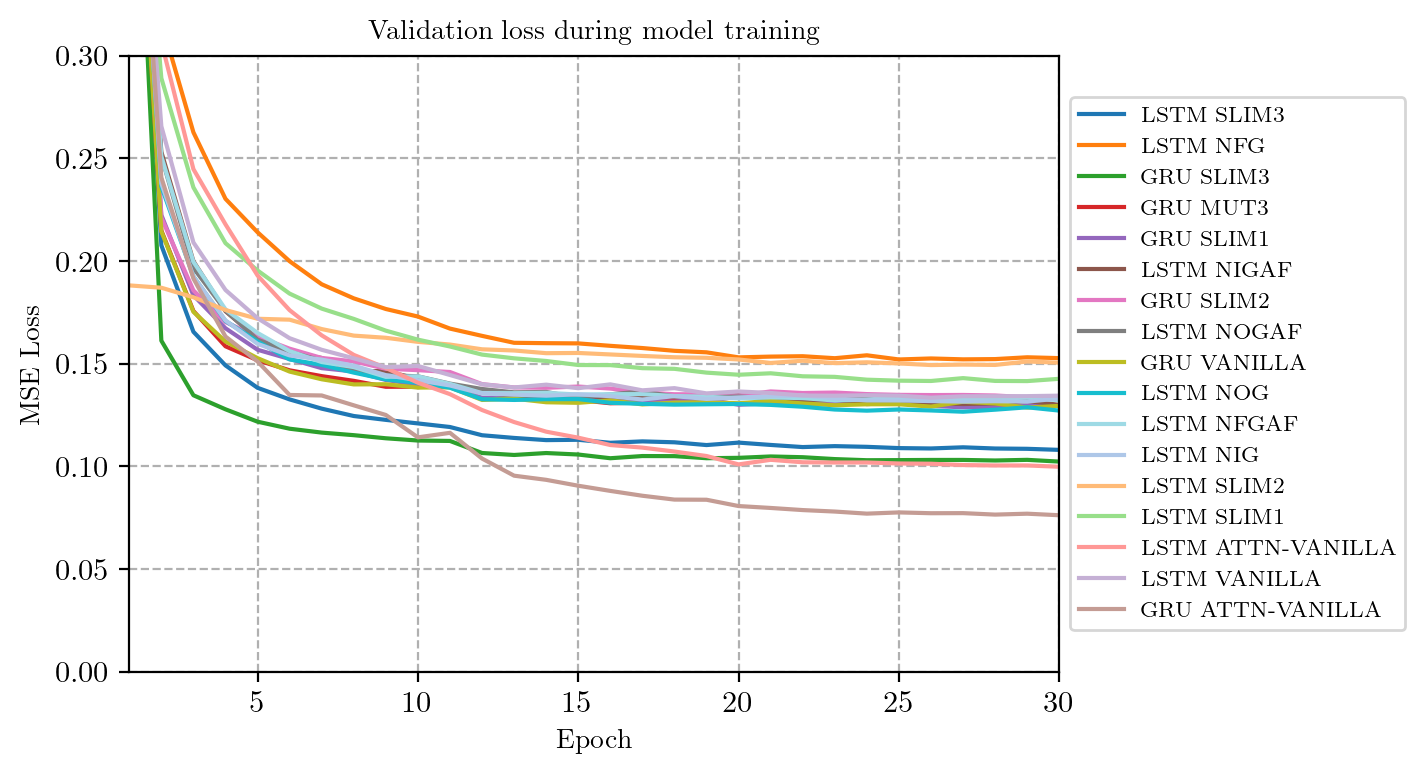

In [6]:
cmap = plt.get_cmap('tab20')
colors = [cmap(i) for i in range(0,21,2)] + \
         [cmap(i+1) for i in range(0,21,2)]

# Get images folder and filepath
imagesfolder = os.path.join(utils.cwd, 'images')
filepath = os.path.join(imagesfolder,'training_validation_loss.pdf')

# Iterate over all elements in the folder
fig, ax = plt.subplots(figsize=(6,4))

# Iterate over all trained network
for i, (network_name, data) in enumerate(data_plot.items()):

    data = pd.Series(data['validation_loss'], data['epochs'])
            
    ax.plot(data.drop_duplicates(keep='first'), 
            label = network_name.replace('_',' ').upper(), 
            color = colors[i])

ax.set_title('Validation loss during model training', fontsize=10)
ax.set_xlabel('Epoch', fontsize=10)
ax.set_ylabel('MSE Loss', fontsize=10)
ax.set_ylim(0,0.3)
ax.set_xlim(1, 30)
ax.legend(fontsize=8, loc='center left', bbox_to_anchor=(1, 0.5))
ax.grid(True, linestyle='--')
fig.savefig(filepath, bbox_inches='tight')

### 3.2.- Training one of the networks

#### 3.2.1 - Model instanciation

In [ ]:
# Set the network to train.
network_name = 'lstm_slim1'

# Get model's filename where the parameters are saved.
filename = f'cef_{network_name}_' + \
           f'hs{df_networks.loc[network_name]["hidden_size"]}_' + \
           f'nl{df_networks.loc[network_name]["num_layers"]}_parameters.pt'

# Get filepath for the model and print it        
filepath = os.path.join(utils.cwd, 'models', filename)

if not os.path.exists(filepath):
    print(f'Model parameters not found in {filepath}')
else:
    
    print(f'Model filename: {filename}')

    # Get the network object
    network = networks[network_name]

    # Initialize model.
    model = xnn.ConjunctionEventForecaster(network = network, 
                                           features = nn_features)


#### 3.2.2.- Training the model

In [ ]:
# Train the model
model.learn(events_train_and_val, epochs = 20, lr = 1e-5, batch_size = 15, 
            device = 'cpu', event_samples_for_stats = 2000)

# Print the last validation losses to see if model has improved over the last
# iterations.
print('\nLast 5 validation losses:')
display(pd.Series(model._learn_results['validation_loss'],
                  model._learn_results['epoch'])
                  .drop_duplicates(keep='first')
                  .sort_index(ascending=False).head(5))

#### 3.2.3.- Using the model to forecast Conjunction Events

In [ ]:
# Take a single event from test dataset and remove the last CDM.
event_idx = 2
event = events_test[event_idx]
event_beginning = event[0:len(event)-1]

# Print information about the event to forecast.
print(f'Forecasting next CDM from previous {len(event)} CDM(s)...')

# Predict the evolution of the conjunction event until TCA or the number of CDMs
# is max_length.
event_evolution = model.predict_event(event = event_beginning, 
                                      num_samples = 10, 
                                      max_length = 14)

# List of features to predict.
features = ['RELATIVE_SPEED', 'MISS_DISTANCE', 'OBJECT1_CT_T']

# Plot prediction in red
axs = event_evolution.plot_features(features = features, return_axs = True, 
                                    linewidth = 0.1, color = 'red', alpha=0.33, 
                                    label = 'Prediction')
#and the ground truth value in blue:
event.plot_features(features=features, axs=axs, label='Actual', legend = True)

## Comparing models performance

In [7]:
reload(xnn)
# Get directory where the model parameters are saved.
folderpath = os.path.join(utils.cwd, 'models')

# Define batch_size for test
test_batch_size = 10

# Initialiaze dictionary to store the list
data_test = {}

# Initialize progress bar.
pb_networks = utils.ProgressBar(iterations=range(len(networks)),
                                title='TESTING NETWORKS PERFORMANCE:')
# Iterate over all available networks
for n, (network_name, network) in enumerate(networks.items()):
    
    filepath = ''
    for filename in os.listdir(folderpath):
        if '_' + network_name + '_' in filename: 
            filepath = os.path.join(folderpath, filename)
            break

    if filepath=='': continue

    # Initialize model.
    model = xnn.ConjunctionEventForecaster(network = network, 
                                           features = nn_features)
    
    # Load parameters into the model
    model.load(filepath = filepath)

    # Test model usinf the events_test dataset.
    test_results = model.test(events_test, test_batch_size = test_batch_size)

    # Add data to the dictionary.
    data_test[network_name] = test_results

    # Update progress bar
    description = f'Network: {network_name:12} ' + \
                  f'MSE -> Mean = {np.mean(test_results["mse"]):6.4e}' + \
                  f'Std. Dev = {np.std(test_results["mse"]):6.4e}'
    pb_networks.refresh(i=n+1, description=f'Network: {network_name}')



TESTING NETWORKS PERFORMANCE:
| Progress                 |    Time     | Iters/sec | Comments
| 100% |██████████| (17/17)| 00h:07m:17s |   0.04    | Network: gru_attn-vanilla 


In [12]:
# Model evaluation metrics:
# - SSE (Sum of Squared Errors)
# - MSE (Mean Squared Errors)
# - MAE (Mean Absolute Errors)
# - AIC (Akaike Information Criterion)
# - BIC (Bayesian Information Criterion): When fitting models, it is possible to 
#   increase the likelihood by adding parameters, but doing so may result in 
#   overfitting. BIC introduces a penalty term for the number of parameters in 
#   the model. The penalty term is larger in BIC than in AIC.

# Initialize dictionary to store the results from the different regression 
# evaluation metrics
data_stats = {}

df_stats = pd.DataFrame(index = list(data_test.keys()))
for metric in ['mse', 'mae', 'sse', 'aic', 'bic']:

    # Get metric results from all networks evaluated
    for network_name, network_data in data_test.items():
        data_stats[network_name] = network_data[metric]

    # Convert dictionary to Pandas DataFrame.
    df_metric = pd.DataFrame.from_dict(data=data_stats, orient='columns')
    
    # Transpose DataFrame and rename columns
    df_metric = df_metric.describe().transpose()
    df_metric = df_metric[['mean', 'std','50%']] \
                    .rename(columns={'mean':f'{metric}_mean', 
                                     'std':f'{metric}_std',
                                     '50%':f'{metric}_median'})
    
    # Append metric DataFrame to final dataframe
    df_stats = pd.concat([df_stats, df_metric], axis=1)

df_stats.sort_values(by='mse_mean', ascending=True, inplace=True)

# Compute deltas vs min values for AIC and BIC scores
df_stats['aic_delta'] = df_stats['aic_mean']-df_stats['aic_mean'].min()
df_stats['bic_delta'] = df_stats['bic_std']-df_stats['bic_std'].min()

# Save to CSV regression scores.
df_stats.to_csv('networks_test_regression_scores.csv')

# Show DataFrame
display(df_stats)

,mse_mean,mse_std,mse_median,mae_mean,mae_std,mae_median,sse_mean,sse_std,sse_median,aic_mean,aic_std,aic_median,bic_mean,bic_std,bic_median,aic_delta,bic_delta
gru_attn-vanilla,0.097719,0.035888,0.084714,0.130284,0.023886,0.126990,1354.388300,497.407318,1174.129211,1.844404e+06,3.666823,1.844404e+06,2.123442e+06,3.666823,2.123441e+06,0.000000,0.667115
lstm_attn-vanilla,0.124907,0.050546,0.115805,0.140060,0.026968,0.130203,1731.204608,700.569208,1605.056152,1.853983e+06,3.998237,1.853983e+06,2.134469e+06,3.998237,2.134469e+06,9578.332629,0.998530
gru_slim3,0.126840,0.061325,0.092540,0.128135,0.018959,0.130378,1757.997931,849.961422,1282.601501,1.851591e+06,4.564834,1.851589e+06,2.131715e+06,4.564834,2.131713e+06,7186.229395,1.565126
lstm_slim3,0.133313,0.055378,0.118651,0.132274,0.019792,0.124083,1847.713086,767.536095,1644.498352,1.853385e+06,4.378471,1.853385e+06,2.133781e+06,4.378471,2.133781e+06,8980.882150,1.378764
gru_vanilla,0.154829,0.060291,0.151978,0.156817,0.037145,0.157234,2145.924670,835.627106,2106.410461,1.850873e+06,4.072230,1.850873e+06,2.130888e+06,4.072230,2.130889e+06,6468.479689,1.072523
lstm_nigaf,0.157148,0.063049,0.157730,0.160768,0.029514,0.158628,2178.076678,873.853474,2186.141113,1.855577e+06,4.309798,1.855578e+06,2.136304e+06,4.309798,2.136305e+06,11172.558396,1.310090
gru_mut3,0.157317,0.048463,0.152144,0.157609,0.026470,0.160329,2180.411438,671.697114,2108.712769,1.854545e+06,3.073796,1.854546e+06,2.135116e+06,3.073796,2.135116e+06,10140.936856,0.074088
lstm_nog,0.158144,0.090363,0.126385,0.155118,0.033244,0.155751,2191.877942,1252.426983,1751.695068,1.854545e+06,5.315189,1.854544e+06,2.135115e+06,5.315189,2.135114e+06,10140.086383,2.315481
lstm_nogaf,0.158875,0.072224,0.136607,0.160530,0.026179,0.163172,2202.011719,1001.021932,1893.379211,1.855577e+06,3.734241,1.855576e+06,2.136304e+06,3.734241,2.136303e+06,11172.746427,0.734533
lstm_nig,0.158918,0.076606,0.136433,0.156998,0.022929,0.156186,2202.606946,1061.756097,1890.965027,1.854545e+06,4.319920,1.854544e+06,2.135116e+06,4.319920,2.135115e+06,10140.561397,1.320212


In [13]:
# Initialize dictionary to store the MSE loss per model and batch.
data_mse = {}
for network_name, network_data in data_test.items():
    data_mse[network_name] = network_data['mse']

# Convert dictionary to Pandas DataFrame (rows = batch, columns = networks).
df_test_mse = pd.DataFrame.from_dict(data = data_mse, orient='columns')

# Reorder the columns in the original dataset to be ordered by the loss mean
df_test_mse = df_test_mse[df_stats.index]

# Save results in a CSV file.
df_test_mse.to_csv(f'networks_test_mse_bs{test_batch_size}.csv')

display(df_test_mse)

,gru_attn-vanilla,lstm_attn-vanilla,gru_slim3,lstm_slim3,gru_vanilla,lstm_nigaf,gru_mut3,lstm_nog,lstm_nogaf,lstm_nig,lstm_nfgaf,gru_slim1,lstm_vanilla,gru_slim2,lstm_slim1,lstm_nfg,lstm_slim2
0,0.144307,0.092456,0.150266,0.145146,0.180762,0.067728,0.179392,0.201039,0.092469,0.089234,0.164462,0.064111,0.161832,0.103891,0.117448,0.180108,0.347110
1,0.046216,0.070982,0.087273,0.122871,0.132523,0.096687,0.131372,0.081637,0.146340,0.110811,0.197979,0.139765,0.150019,0.262596,0.260763,0.236004,0.066914
2,0.080556,0.112750,0.242245,0.188675,0.156594,0.269160,0.150362,0.076083,0.136380,0.190623,0.138685,0.112902,0.161902,0.305155,0.180316,0.140001,0.164462
3,0.166423,0.216502,0.091263,0.114430,0.258769,0.102267,0.229123,0.084558,0.136835,0.153665,0.236379,0.276442,0.200958,0.075047,0.171423,0.283421,0.201601
4,0.082831,0.195268,0.067776,0.087293,0.183052,0.215362,0.242201,0.132815,0.334574,0.150566,0.125500,0.141444,0.239178,0.089826,0.068162,0.165472,0.078687
5,0.072462,0.122363,0.082769,0.053747,0.091218,0.111923,0.153925,0.203146,0.130558,0.251519,0.099999,0.101729,0.163904,0.267329,0.305789,0.190773,0.260970
6,0.079248,0.063533,0.074209,0.232271,0.079005,0.153765,0.120607,0.090612,0.115293,0.091860,0.194447,0.131645,0.212384,0.141510,0.124926,0.200839,0.394798
7,0.100274,0.098903,0.093816,0.189885,0.088627,0.194123,0.086768,0.119955,0.147282,0.122300,0.270676,0.107301,0.106257,0.104793,0.159111,0.072468,0.189845
8,0.118279,0.157448,0.185398,0.109109,0.147361,0.161695,0.157191,0.355228,0.234481,0.323837,0.076005,0.139667,0.143086,0.217084,0.287927,0.146874,0.098838
9,0.086596,0.118860,0.193381,0.089698,0.230375,0.198774,0.122226,0.236367,0.114540,0.104767,0.092557,0.383226,0.089677,0.091181,0.133754,0.223245,0.074353


In [42]:
# Display test loss dataframe and statistics
#df_test_mse = pd.read_csv('networks_test_mse_bs10.csv',index_col=0)

# Get mean, standard deviation, and median 
df_test_mse_stats = df_stats[[c for c in df_stats.columns if c[:3]=='mse']]

# Get MSE results from LSTM network with Vanilla cell architecture (Kessler)
mse_vanilla = df_stats.loc['lstm_vanilla']['mse_mean']

df_test_mse_stats['delta'] = 1 - df_test_mse_stats['mse_mean']/mse_vanilla

display(df_test_mse_stats)

/var/folders/m2/1phpry2j5w739bgs4cqbg0pw0000gn/T/ipykernel_45339/4210431033.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_mse_stats['delta'] = 1 - df_test_mse_stats['mse_mean']/mse_vanilla


,mse_mean,mse_std,mse_median,delta
gru_attn-vanilla,0.097719,0.035888,0.084714,0.400201
lstm_attn-vanilla,0.124907,0.050546,0.115805,0.233325
gru_slim3,0.126840,0.061325,0.092540,0.221460
lstm_slim3,0.133313,0.055378,0.118651,0.181729
gru_vanilla,0.154829,0.060291,0.151978,0.049664
lstm_nigaf,0.157148,0.063049,0.157730,0.035425
gru_mut3,0.157317,0.048463,0.152144,0.034391
lstm_nog,0.158144,0.090363,0.126385,0.029313
lstm_nogaf,0.158875,0.072224,0.136607,0.024826
lstm_nig,0.158918,0.076606,0.136433,0.024562


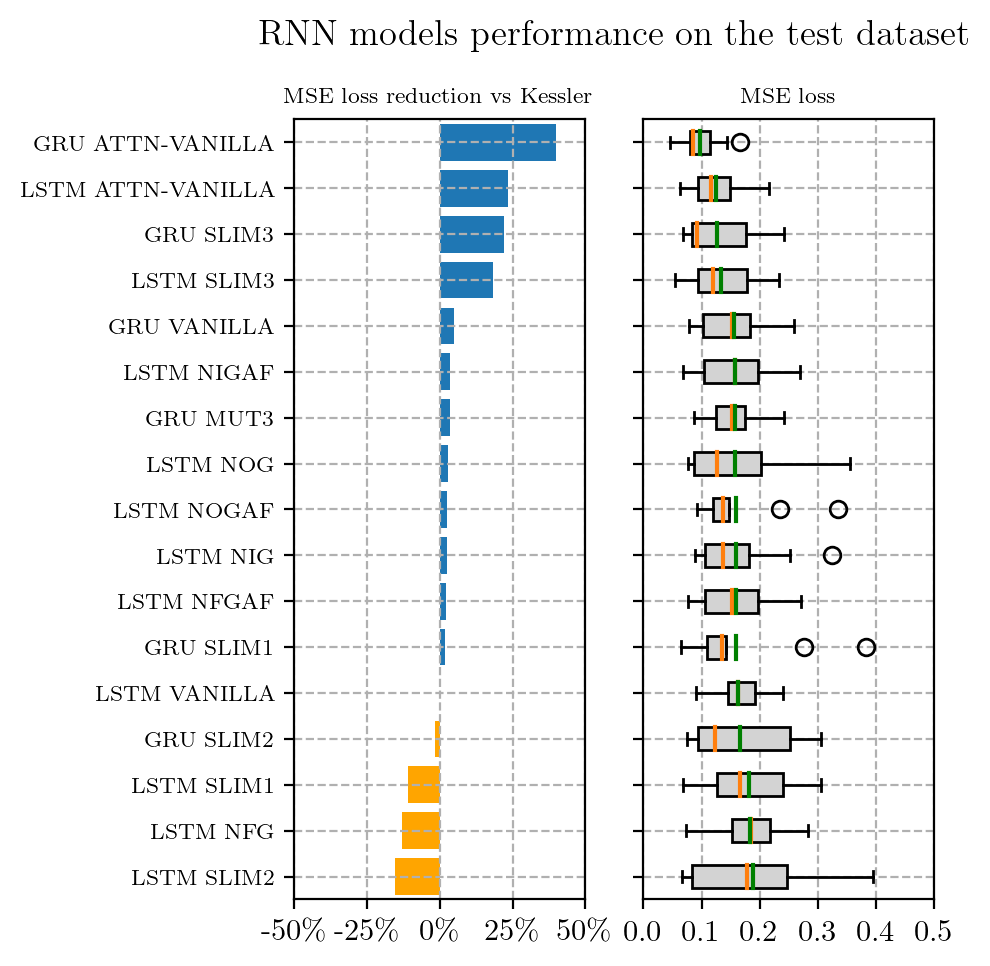

In [44]:
import matplotlib.ticker as mtick

fig, (ax_hb, ax_bp) = plt.subplots(nrows=1, ncols=2, figsize=(4,5), sharey=True)

fig.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    wspace=0.2,
                    hspace=0.4)

# Set the figure title
fig.suptitle('RNN models performance on the test dataset') 

# Get the labels for the Y-axis
labels = [l.replace('_',' ').upper() for l in df_test_mse.columns]

# Plot the boxplot

ax_bp.boxplot(df_test_mse, positions = np.arange(len(labels)), 
              vert = False, showmeans = True, meanline = True, 
              meanprops = dict(linestyle='-', linewidth=1.5, color='green'), 
              medianprops = dict(linewidth=1.5), 
              boxprops = dict(facecolor = "lightgrey"), 
              showfliers = True, patch_artist=True)

# Set the Y-axis labels to the right position for the boxplot.
#ax_bp.yaxis.set_ticks_position('right')

# Set the X-axis label and ticks for the boxplot
ax_bp.set_title('MSE loss', fontsize=8)
ax_bp.set_xticks(np.linspace(0,0.5,6))

# Plot horizontalm bars with the delta.
colors = ['tab:blue']*sum(df_test_mse_stats['delta']>0) + \
    ['orange']*sum(df_test_mse_stats['delta']<=0)

ax_hb.barh(labels, df_test_mse_stats['delta'], color = colors, align='center')

# Set the X-axis label and format for the ticks
ax_hb.set_title('MSE loss reduction vs Kessler', fontsize=8)
ax_hb.xaxis.set_major_formatter(mtick.PercentFormatter(xmax=1))

# Set the limits and ticks for the horizontal bar plot
ax_hb.set_xlim(-0.5,0.5)
ax_hb.set_xticks(np.linspace(-0.5,0.5,5))


# Set general format for both plots 
for ax in [ax_bp, ax_hb]: ax.grid(True, linestyle='--')
ax_hb.set_yticklabels(labels, fontsize=8)
       
ax_hb.invert_yaxis()

figpath = os.path.join(utils.cwd,'notebooks','images','rnn_models_performance')
fig.savefig(figpath + '.pdf', bbox_inches = "tight")
